<a href="https://colab.research.google.com/github/JericCantos/CIFAR10-CNN-TransferLearning/blob/main/notebooks/CIFAR_10_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This project compares the performance of transfer learning models based on ResNet50 against a custom-made CNN when it comes to classifying images from CIFAR-10

Two variants of each model were tested: a baseline and a tweaked version.

## CIFAR-10

https://www.cs.toronto.edu/~kriz/cifar.html

- 60,000 32x32 RGB Images
- 10 classes with 6,000 images each
- 50,000 training images, 10,000 test images


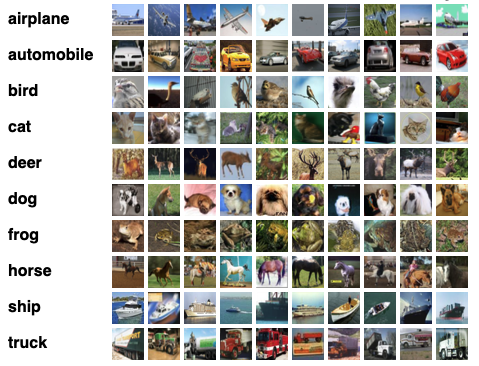

## Models

1. **ResNet50 Baseline**
- two dense layers and an output layer on top of ResNet50.
- 10,000 training images for 10 epochs
2. **ResNet50 Unfrozen**
- The last 30 layers of ResNet50 were retrained on the dataset.
- also trained on the same 10,000 training images for 10 epochs
- each epoch already pushed past 300 seconds, so training on the full 50,000 images was not attempted.
3. **Custom CNN Baseline**
- 4 convolutional layers feeding just one dense layer before the output.
- trained on 10,000 images for 10 epochs
4. **Custom CNN Max**
- the same custom CNN architecture but trained on all 50,000 images.
- alloted 50 epochs with early stopping criteria.

# Conclusion

| | ResNet50 Baseline | ResNet50 Unfrozen | Custom CNN Baseline | Custom CNN Max |
| - | - | -  | - | - |
| accuracy | 31% | 33% | 65% | 83% |
| weighted avg. F1 score | 28%  | 32% | 65%  | 83% |

The "simpler" CNNs built from scratch performed much, much better than the models built on top of ResNet50 (52% better accuracy and 55% better weighted average F1 score between the best model and the worst model). This could be due to a number of things:

- ResNet50 was intended to get 224x224 images while our data were only 32x32. Upscaling may have an impact but I am doubtful.
- We only used 10,000 images to train the model. Using the full 50,000 training images may improve the model's performance, but would likely take much, much more time.
- The fully-connected neural network on top of the base model only had 128 and 64 neurons respectively. Perhaps increasing the number of neurons would also positively affect performance.
- We only trained for 10 epochs. The losses were still a bit high and ccould possible plunge further with longer training.


It would be interesting to try data augmentation as well (for all variants) to see if the increased number of training images would further improve model performance.

## ResNet50 Results

| ResNet50 Baseline | ResNet50 Unfrozen |
| - | - |
| 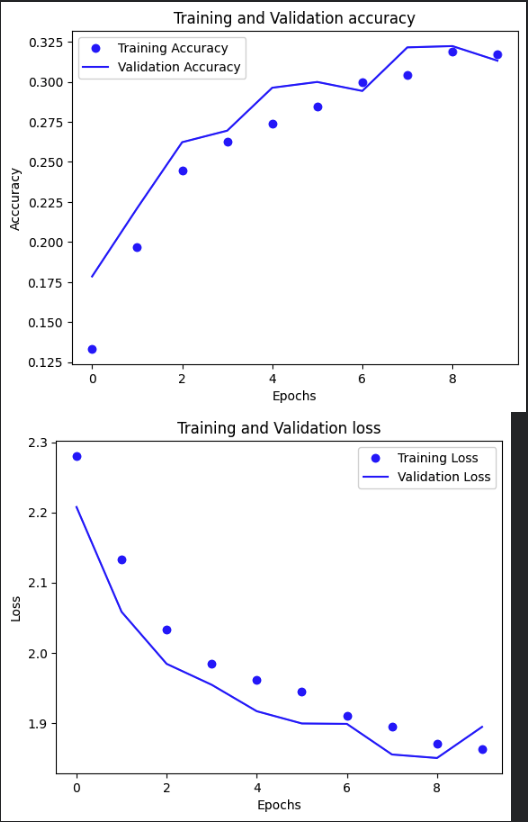 | 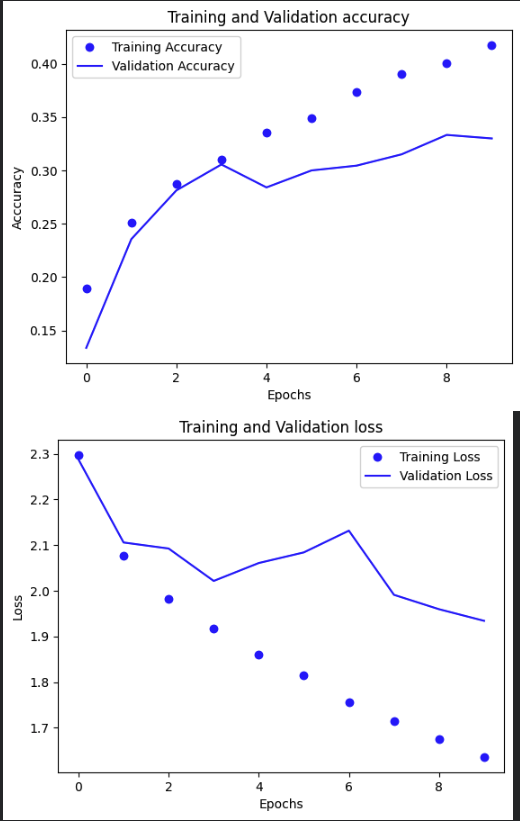|
| 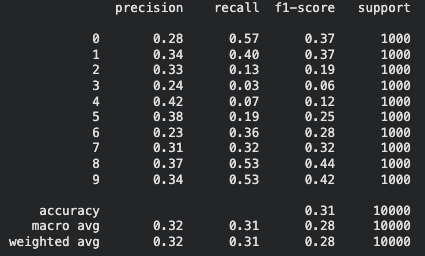| 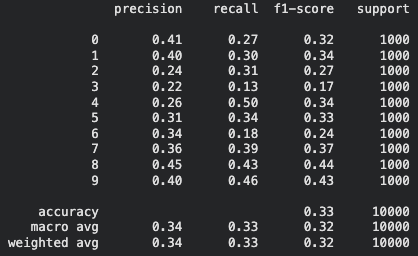 |

## Custom CNN Results

| Custom CNN Baseline | Custom CNN Max |
| - | - |
|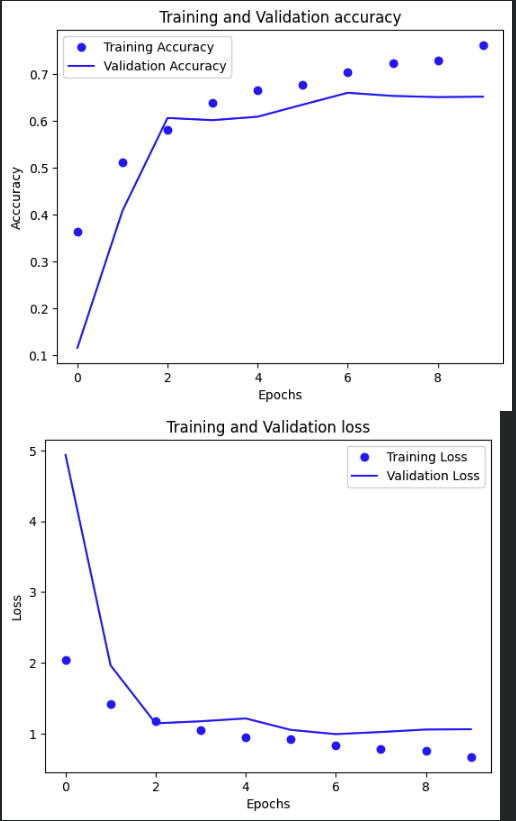 | 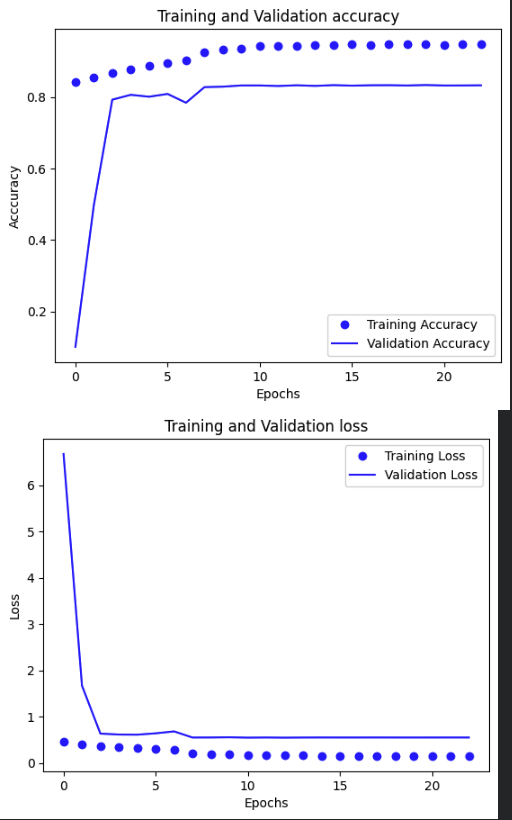|
|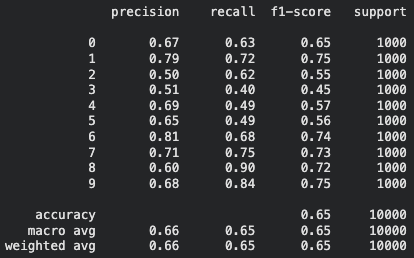 | 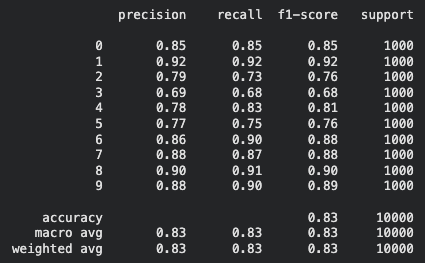|

# Load Libraries

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# Load Dataset

In [ ]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [ ]:
print ("training images:", len(train_images))
print ("test images:", len(test_images))

training images: 50000
test images: 10000


In [ ]:
# Flatten labels to shape (50000,)
train_labels_flat = train_labels.squeeze()

# Parameters
num_classes = 10
n_per_class = 1000

# For reproducibility
np.random.seed(42)

# Store the selected indices
balanced_indices = []

for cls in range(num_classes):
    # Get all indices of this class
    cls_indices = np.where(train_labels_flat == cls)[0]
    # Randomly choose 1,000 of them
    chosen = np.random.choice(cls_indices, n_per_class, replace=False)
    balanced_indices.extend(chosen)

# Shuffle them
np.random.shuffle(balanced_indices)

# Now subset both images and labels
train_images_balanced = train_images[balanced_indices]
train_labels_balanced = train_labels[balanced_indices]

# Check class balance
import pandas as pd
print(pd.Series(train_labels_balanced.squeeze()).value_counts().sort_index())


0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
7    1000
8    1000
9    1000
Name: count, dtype: int64


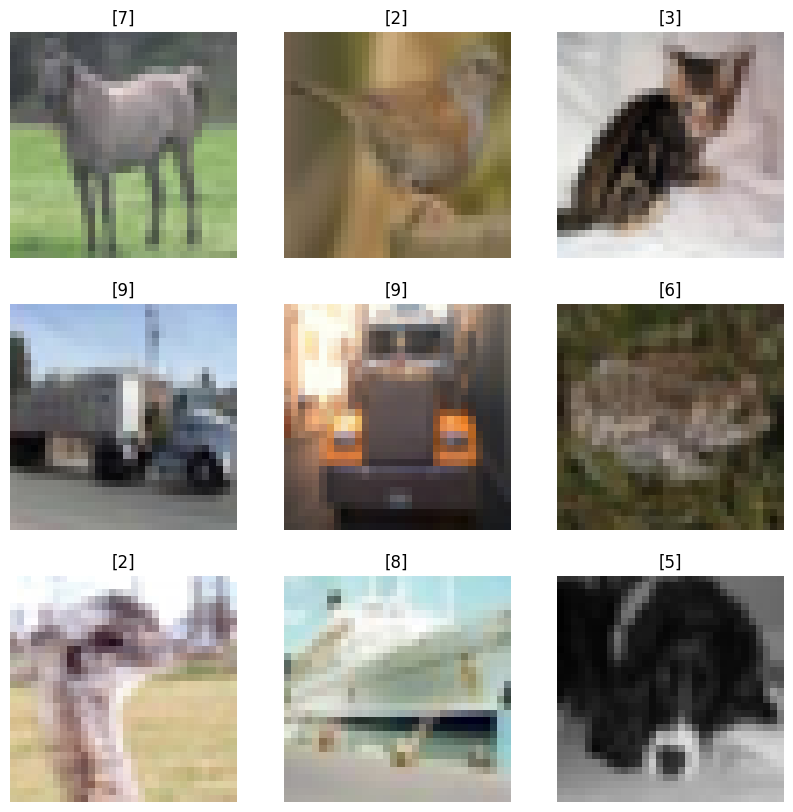

In [ ]:
# Function to plot 9 sample images from the training data
def visualize_data(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(0, 9):  # Take 9 examples
        image = images[i]
        label = labels[i]
        plt.subplot(3, 3, i+1) # building a grid to display images
        plt.imshow(image) # showing images
        plt.title(label) # setting a title
        plt.axis('off')
    plt.show()


# Visualize the training data by calling the function
visualize_data(train_images_balanced,  train_labels_balanced)

# Data Preprocessing

The images from the CIFAR-10 dataset are 32x32x3 (RGB) images, which are fitting for the `ResNet50` CNN. Preprocessing would then only involve normalization.

In [ ]:
train_images_balanced = train_images_balanced / 255.0
test_images = test_images / 255.0

In [ ]:
train_images_balanced.shape

(10000, 32, 32, 3)

In [ ]:
test_images.shape

(10000, 32, 32, 3)

# Helper Functions

In [ ]:
def train_validation_plot(history):
  # plot the train and validation accuracy and loss
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(accuracy))
  plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
  plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Acccuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [ ]:
def print_classification_report(model):
  y_pred = model.predict(test_images,verbose=0)
  y_pred = np.argmax(y_pred,axis=1)

  print(classification_report(test_labels, y_pred))

# ResNet50 Baseline Model Setup

We will use `sparse_categorical_crossentropy` as the labels are already integer values and there's no need for us to do one-hot encoding.

In [ ]:
# Load the ResNet50 model, excluding the top classification layers
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(32, 32, 3))

# Freeze the base model to retain its pre-trained weights
base_model.trainable = False

In [ ]:
# Build the neural network model
model = models.Sequential([
    base_model,
    # Converts the feature maps into a single vector
    layers.GlobalAveragePooling2D(),
    # Two hidden layers
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    # Final layer with 10 outputs for 10 classes
    layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,890 (91.01 MB)

 Trainable params: 271,178 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Train the model
history = model.fit(train_images_balanced, train_labels_balanced, epochs=10,
                    validation_data=(test_images,
                    test_labels))

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 88s 268ms/step - accuracy: 0.1141 - loss: 2.3143 - val_accuracy: 0.1785 - val_loss: 2.2077
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 76s 243ms/step - accuracy: 0.1799 - loss: 2.1736 - val_accuracy: 0.2211 - val_loss: 2.0583
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 76s 242ms/step - accuracy: 0.2253 - loss: 2.0584 - val_accuracy: 0.2623 - val_loss: 1.9842
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 86s 256ms/step - accuracy: 0.2547 - loss: 1.9958 - val_accuracy: 0.2695 - val_loss: 1.9544
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 78s 244ms/step - accuracy: 0.2678 - loss: 1.9698 - val_accuracy: 0.2963 - val_loss: 1.9167
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 87s 259ms/step - accuracy: 0.2809 - loss: 1.9503 - val_accuracy: 0.2999 - val_loss: 1.8992
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 80s 255ms/step - accuracy: 0.2958 - loss: 1.9159 - val_accuracy: 0.2943 - val_loss: 1.8986
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 259ms/step - accuracy: 0.2916 - loss: 1

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images[:1000],
        test_labels[:1000])
print('Test Loss : {:.4f}'.format(test_loss))
print('Test accuracy: {:.4f}'.format(test_accuracy))

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.3325 - loss: 1.8537
Test Loss : 1.8584
Test accuracy: 0.3160


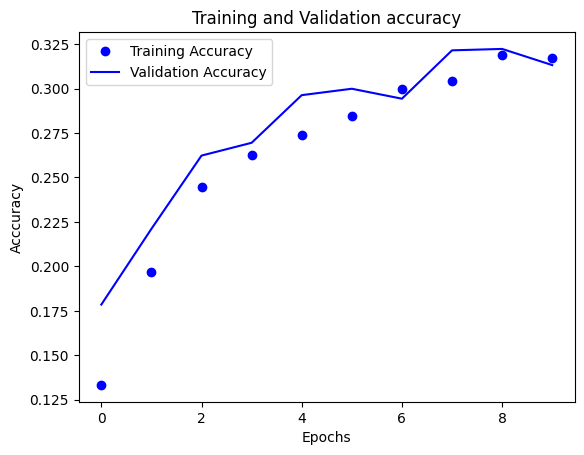

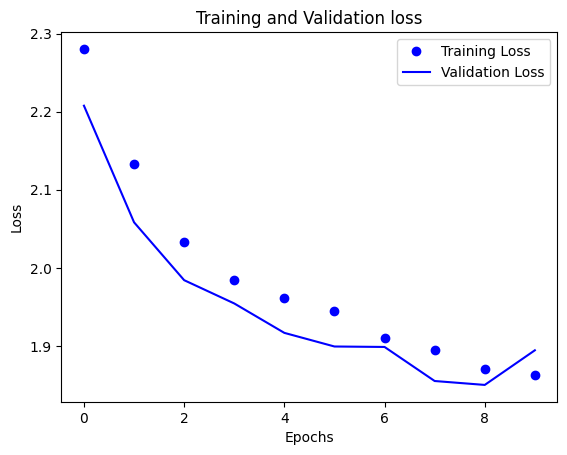

In [ ]:
train_validation_plot(history)

Training accuracy actually and loss seem to track validation accuracy and loss quite well, indicating that over- or underfitting is not an issue. However, overall accuracy is quite low at just about 32%. This could be due to a few reasons:

1. ResNet50 has a recommended image input size of 224x224, unlike our 32x32 images (https://www.mathworks.com/help/deeplearning/ref/resnet50.html)
2. We only used 10,000 images to train.
3. We only trained for 10 epochs.

In [ ]:
print_classification_report(model)

              precision    recall  f1-score   support

           0       0.28      0.57      0.37      1000
           1       0.34      0.40      0.37      1000
           2       0.33      0.13      0.19      1000
           3       0.24      0.03      0.06      1000
           4       0.42      0.07      0.12      1000
           5       0.38      0.19      0.25      1000
           6       0.23      0.36      0.28      1000
           7       0.31      0.32      0.32      1000
           8       0.37      0.53      0.44      1000
           9       0.34      0.53      0.42      1000

    accuracy                           0.31     10000
   macro avg       0.32      0.31      0.28     10000
weighted avg       0.32      0.31      0.28     10000



The model seems to be quite bad at identifying class 3 images i.e. CATS! This will not stand. Only 24% of images it predicted as cats were indeed cats (precision), and it was only able to find 3% of all cats in the dataset (recall).

# ResNet50 Fine-Tuning: Unfreeze top 30 layers

In [ ]:
base_model.trainable = True

# Fine-tune from this layer onwards (e.g., last 30 layers)
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # smaller LR for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,301,600 (203.33 MB)

 Trainable params: 14,721,354 (56.16 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

 Optimizer params: 29,442,710 (112.32 MB)

In [ ]:
# Train the model
history_unfrozen = model.fit(train_images_balanced, train_labels_balanced, epochs=10,
                    validation_data=(test_images,
                    test_labels))

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 305s 975ms/step - accuracy: 0.1763 - loss: 2.3935 - val_accuracy: 0.1336 - val_loss: 2.2873
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 304s 973ms/step - accuracy: 0.2478 - loss: 2.0898 - val_accuracy: 0.2355 - val_loss: 2.1057
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 318s 960ms/step - accuracy: 0.2840 - loss: 2.0003 - val_accuracy: 0.2812 - val_loss: 2.0925
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 301s 964ms/step - accuracy: 0.3041 - loss: 1.9162 - val_accuracy: 0.3055 - val_loss: 2.0215
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 299s 953ms/step - accuracy: 0.3341 - loss: 1.8742 - val_accuracy: 0.2840 - val_loss: 2.0607
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 300s 960ms/step - accuracy: 0.3470 - loss: 1.8118 - val_accuracy: 0.2999 - val_loss: 2.0840
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 300s 958ms/step - accuracy: 0.3743 - loss: 1.7512 - val_accuracy: 0.3044 - val_loss: 2.1315
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 303s 966ms/step - accuracy: 0.3978 -

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images[:1000],
        test_labels[:1000])
print('Test Loss : {:.4f}'.format(test_loss))
print('Test accuracy: {:.4f}'.format(test_accuracy))

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.3158 - loss: 1.9205
Test Loss : 1.9217
Test accuracy: 0.3100


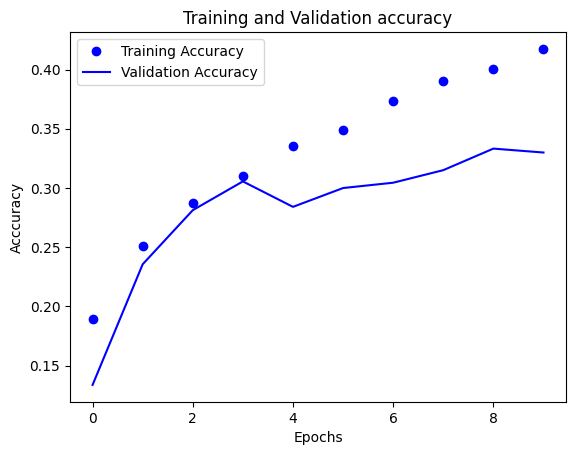

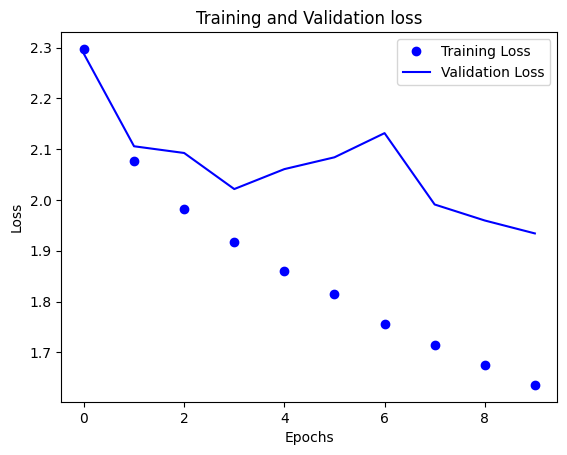

In [ ]:
train_validation_plot(history_unfrozen)

In [ ]:
print_classification_report(model)

              precision    recall  f1-score   support

           0       0.41      0.27      0.32      1000
           1       0.40      0.30      0.34      1000
           2       0.24      0.31      0.27      1000
           3       0.22      0.13      0.17      1000
           4       0.26      0.50      0.34      1000
           5       0.31      0.34      0.33      1000
           6       0.34      0.18      0.24      1000
           7       0.36      0.39      0.37      1000
           8       0.45      0.43      0.44      1000
           9       0.40      0.46      0.43      1000

    accuracy                           0.33     10000
   macro avg       0.34      0.33      0.32     10000
weighted avg       0.34      0.33      0.32     10000



The gap between train and test accuracy and loss is wider than with the baseline moodel. However, model performance increased slightly, going too 33% from 31% as per the classification report. F1 scores also imrpoved. Most importantly, although the model's precision for cats dropped from 24% to 22%, it was now at least able to identify 13% of all cats in the dataset, which is a 10-point increase.

The model training time for this variant was substantially longer, however.

# Custom CNN Baseline

Creating a custom CNN with a few layers to compare against transfer learning with ResNet50

In [ ]:
# use padding to preserve the dimensions of the input layer
custom_cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same',
                  input_shape=(32,32,3)),
    layers.BatchNormalization(),
          # easier convergence, prevent eploding/vanishing gradients
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

custom_cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
custom_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,171,178 (8.28 MB)

 Trainable params: 2,169,770 (8.28 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [ ]:
# train the model
history_custom_baseline = custom_cnn.fit(train_images_balanced, train_labels_balanced, epochs=10,
                    validation_data=(test_images,
                    test_labels))

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 91s 274ms/step - accuracy: 0.3097 - loss: 2.3688 - val_accuracy: 0.1159 - val_loss: 4.9352
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 252ms/step - accuracy: 0.4886 - loss: 1.4995 - val_accuracy: 0.4086 - val_loss: 1.9660
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 80s 248ms/step - accuracy: 0.5708 - loss: 1.2217 - val_accuracy: 0.6070 - val_loss: 1.1477
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 85s 272ms/step - accuracy: 0.6426 - loss: 1.0316 - val_accuracy: 0.6023 - val_loss: 1.1765
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 78s 248ms/step - accuracy: 0.6750 - loss: 0.9252 - val_accuracy: 0.6097 - val_loss: 1.2169
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 85s 273ms/step - accuracy: 0.6871 - loss: 0.8973 - val_accuracy: 0.6355 - val_loss: 1.0554
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 85s 271ms/step - accuracy: 0.7116 - loss: 0.8093 - val_accuracy: 0.6608 - val_loss: 0.9957
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 85s 271ms/step - accuracy: 0.7466 - loss: 0

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = custom_cnn.evaluate(test_images[:1000],
        test_labels[:1000])
print('Test Loss : {:.4f}'.format(test_loss))
print('Test accuracy: {:.4f}'.format(test_accuracy))

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6718 - loss: 1.0117
Test Loss : 1.0208
Test accuracy: 0.6660


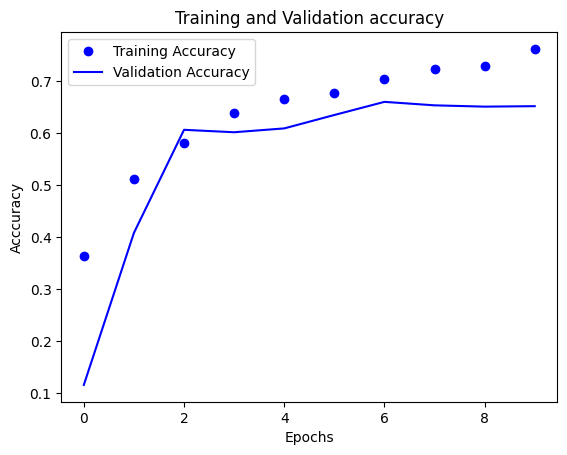

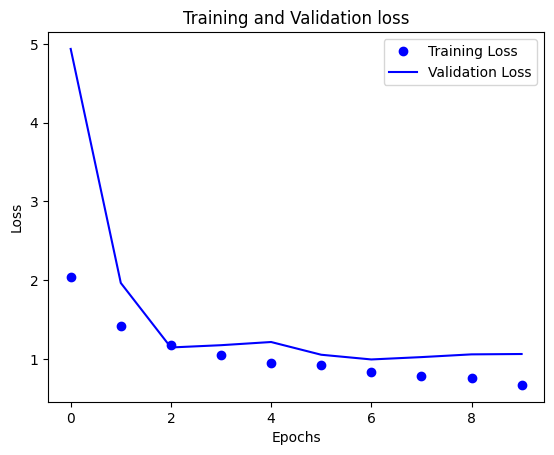

In [ ]:
train_validation_plot(history_custom_baseline)

In [ ]:
print_classification_report(custom_cnn)

              precision    recall  f1-score   support

           0       0.67      0.63      0.65      1000
           1       0.79      0.72      0.75      1000
           2       0.50      0.62      0.55      1000
           3       0.51      0.40      0.45      1000
           4       0.69      0.49      0.57      1000
           5       0.65      0.49      0.56      1000
           6       0.81      0.68      0.74      1000
           7       0.71      0.75      0.73      1000
           8       0.60      0.90      0.72      1000
           9       0.68      0.84      0.75      1000

    accuracy                           0.65     10000
   macro avg       0.66      0.65      0.65     10000
weighted avg       0.66      0.65      0.65     10000



# Custom CNN - Full Training Set, 50 epochs, Early stopping

In [ ]:
# normalize all training images
train_images = train_images / 255.0

In [ ]:
# define early stopping condition and learning rate adjustment
callbacks = [
    callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.2, patience=2)
]

In [ ]:
# recompile the model
custom_cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train the model
history_custom_max = custom_cnn.fit(train_images, train_labels, epochs=50,
                    batch_size=128,
                    validation_data=(test_images, test_labels),
                    callbacks = callbacks)

Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 319s 806ms/step - accuracy: 0.8449 - loss: 0.4378 - val_accuracy: 0.1013 - val_loss: 6.6719 - learning_rate: 0.0010
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 322s 823ms/step - accuracy: 0.8629 - loss: 0.3898 - val_accuracy: 0.4974 - val_loss: 1.6692 - learning_rate: 0.0010
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 323s 827ms/step - accuracy: 0.8712 - loss: 0.3640 - val_accuracy: 0.7927 - val_loss: 0.6330 - learning_rate: 0.0010
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 313s 800ms/step - accuracy: 0.8827 - loss: 0.3308 - val_accuracy: 0.8063 - val_loss: 0.6129 - learning_rate: 0.0010
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 314s 802ms/step - accuracy: 0.8928 - loss: 0.2995 - val_accuracy: 0.8010 - val_loss: 0.6098 - learning_rate: 0.0010
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 331s 826ms/step - accuracy: 0.8997 - loss: 0.2799 - val_accuracy: 0.8088 - val_loss: 0.6391 - learning_rate: 0.0010
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 314s 804ms/step - accura

In [ ]:
best_epoch = callbacks[0].stopped_epoch - callbacks[0].patience
print(f"Best epoch (1-indexed): {best_epoch + 1}")

Best epoch (1-indexed): 13


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = custom_cnn.evaluate(test_images[:1000],
        test_labels[:1000])
print('Test Loss : {:.4f}'.format(test_loss))
print('Test accuracy: {:.4f}'.format(test_accuracy))

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.8428 - loss: 0.4771
Test Loss : 0.5234
Test accuracy: 0.8360


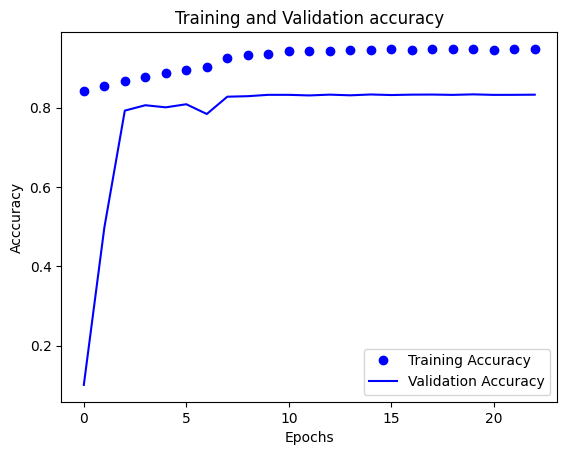

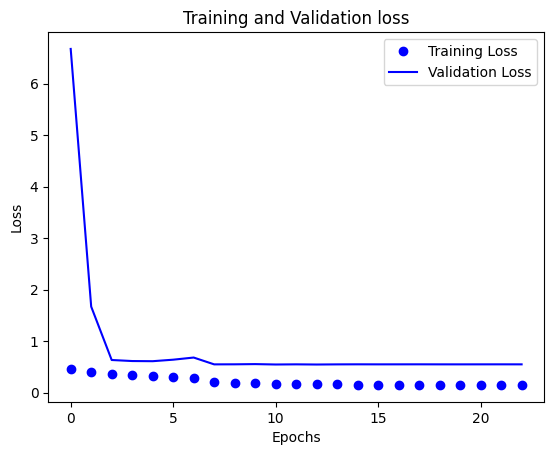

In [ ]:
train_validation_plot(history_custom_max)

In [ ]:
print_classification_report(custom_cnn)

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1000
           1       0.92      0.92      0.92      1000
           2       0.79      0.73      0.76      1000
           3       0.69      0.68      0.68      1000
           4       0.78      0.83      0.81      1000
           5       0.77      0.75      0.76      1000
           6       0.86      0.90      0.88      1000
           7       0.88      0.87      0.88      1000
           8       0.90      0.91      0.90      1000
           9       0.88      0.90      0.89      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



By using the complete set of training images, we were able to improve the prediction accuracy from 65% to 83%. Precision and recall scores improved across the board.

Most notably, this version was able to identify 68% of all cats in the test set, and of all the images it classified as cats, 69% were indeed cats. Nice.

Training this version of the model took 23 epochs out of the 50 allotted. It stopped early as the loss score did not go below that of Epoch 13. Each epoch took about 70 to 100 seconds longer than those of the baseline model.

# Save the Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

save_dir = '/content/drive/MyDrive/Masterschool_Computer_Vision/'
os.makedirs(save_dir, exist_ok=True)  # create folder if it doesn't exist

In [ ]:
model_path = os.path.join(save_dir, 'custom_cnn.keras')
custom_cnn.save(model_path)
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/Masterschool_Computer_Vision/custom_cnn.keras


# Reload the Model

Necessary setup is repeated for simplicity of use.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os

save_dir = '/content/drive/MyDrive/Masterschool_Computer_Vision/'
os.makedirs(save_dir, exist_ok=True)  # create folder if it doesn't exist

In [ ]:
from tensorflow.keras.models import load_model

model_path = os.path.join(save_dir, 'custom_cnn.keras')
custom_cnn = load_model(model_path)
